Different prompts per quadrant experiment

In [1]:
from main import load
import torch
from util import encode_prompt
import math
from nnsight.models.DiffusionModel import DiffusionModel
import matplotlib.pyplot as plt


/share/u/jadenfk/miniconda3/envs/ndif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load diffusion model
model = load()
model._model.pipeline.safety_checker = None



/share/u/jadenfk/miniconda3/envs/ndif/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Keyword arguments {'trust_remote_code': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 15.31it/s]


In [3]:
seed = 3
general_prompt = "forest"
quadrant_prompt = "unicorn"

In [4]:
quadrant_encoding = encode_prompt(quadrant_prompt,  model)

In [5]:
def apply_to_quadrant(output, quadrant: str):

    half_row = output.shape[1] // 2
    half_column = output.shape[2] // 2

    if quadrant == "BR":
        output[-2][half_row:, half_column:] = output[-1][half_row:, half_column:]
    elif quadrant == "TR":
        output[-2][:half_row, half_column:] = output[-1][:half_row, half_column:]
    elif quadrant == "TL":
        output[-2][:half_row, :half_column] = output[-1][:half_row, :half_column:]
    elif quadrant == "BL":
        output[-2][half_row:, :half_column] = output[-1][half_row:, :half_column]

In [6]:
def generate(
    model: DiffusionModel,
    general_prompt: str,
    quadrant_encoding: torch.Tensor,
    seed: int,
    quadrant: str
):

    # Select all cross attentions
    cross_attentions = model.unet.modules(lambda x: x._module_path.endswith("attn2"))

    generator = torch.Generator()
    generator = generator.manual_seed(seed)
    generator2 = torch.Generator()
    generator2 = generator2.manual_seed(seed)

    with model.generate(
        [[general_prompt, general_prompt]],
        output_type="latent",
        generator=[generator, generator2],
        scan=False,
        validate=False,
    ):

        # Apply nnsight interventions to every timestep
        for i in range(50):

            # To inform nnsight were moving on to the next timestep
            if i != 0:
                model.unet.next(propagate=True)

            for cross_attention in cross_attentions:

                # Concatenate the quadrant prompt encoding with the original encoding
                # Encoding shape: (batch size (4 -> 5), n tokens, token dim)
                # Batch size: (control unconditional encoding, control general prompt encoding, edited unconditional encoding, edited general prompt encoding, quadrant prompt encoding)
                new_encoder_hidden_states = torch.concatenate(
                    (
                        cross_attention.input[1]["encoder_hidden_states"],
                        quadrant_encoding[[1]],
                    )
                )
                # Set encoding with our new concatenated one
                cross_attention.input[1][
                    "encoder_hidden_states"
                ] = new_encoder_hidden_states
                
                
                # Also concatenate a copy of the (edited conditional hidden state) to also be a batch size of 5
                # Copy of (edited conditional hidden state) will attend to (quadrant prompt encoding)
                cross_attention.input = (
                    (torch.concatenate((cross_attention.input[0][0], cross_attention.input[0][0][[-1]])),),
                    cross_attention.input[1],
                )

                # Now we have (edited general prompt cross attn output) (batch_idx: 3) and (edited quadrant prompt cross attn output) (batch_idx: 4)
                output = cross_attention.output
                # Convert the collapsed spatial dim (ex 256) to expanded (ex 16x16)
                output = output.view(
                    (
                        output.shape[0],
                        math.floor(math.sqrt(output.shape[1])),
                        math.floor(math.sqrt(output.shape[1])),
                        output.shape[-1],
                    )
                )
                # Copy over the cross attn output from (edited quadrant prompt cross attn output) to (edited general prompt cross attn output) only in selected quadrant
                apply_to_quadrant(output, quadrant)
                
                # Drop the (edited quadrant prompt cross attn output)
                output = output[:-1]
                # Convert spatial dim back to collapsed
                cross_attention.output = output.view((output.shape[0], -1, output.shape[-1]))
                
        latents = model.output.images.save()
        
    latents = latents.value
        
    output = model.vae.decode(latents / model.vae.config.scaling_factor, return_dict=False, generator=[generator, generator2])[
                0
            ]

    output = model.pipeline.image_processor.postprocess(output.detach().cpu(), output_type='pil')
    
    return output


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


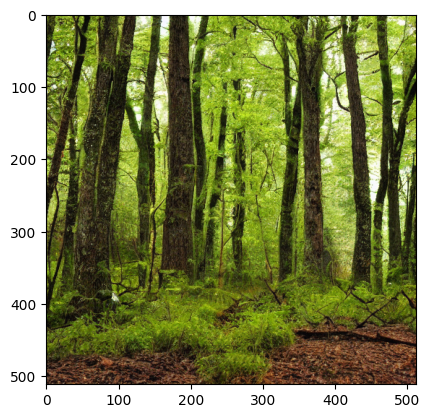

In [7]:
control_image, TR_image = generate(model, general_prompt, quadrant_encoding, seed, 'TR')

plt.imshow(control_image)

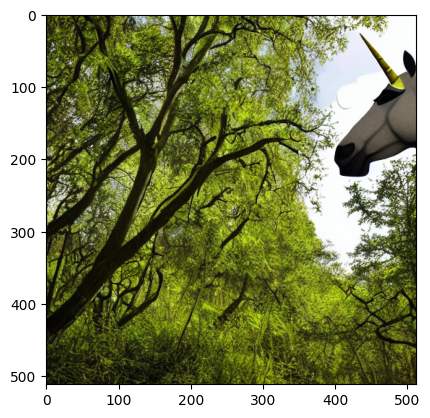

In [8]:
plt.imshow(TR_image)

100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


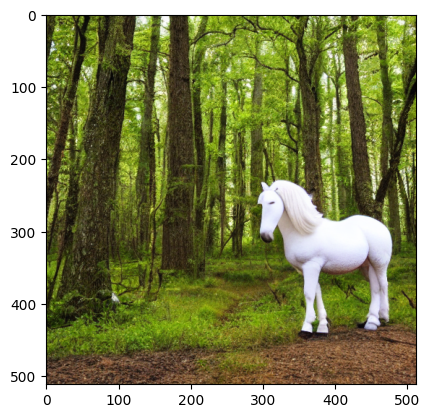

In [9]:
_, BR_image = generate(model, general_prompt, quadrant_encoding, seed, 'BR')

plt.imshow(BR_image)

100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


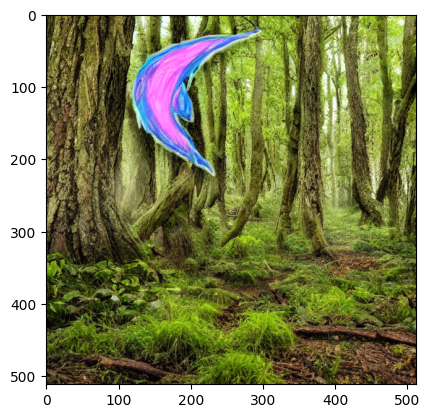

In [10]:
_, TL_image = generate(model, general_prompt, quadrant_encoding, seed, 'TL')

plt.imshow(TL_image)

100%|██████████| 50/50 [00:11<00:00,  4.42it/s]


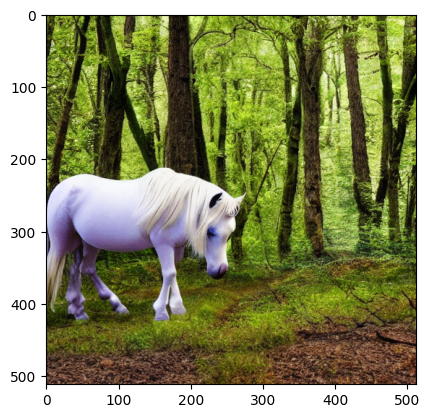

In [11]:
_, BL_image = generate(model, general_prompt, quadrant_encoding, seed, 'BL')

plt.imshow(BL_image)